<a href="https://colab.research.google.com/github/hereagain-Y/TCR_VAE/blob/main/Latent_simultion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.2 MB/s 


In [2]:
from pkgutil import extend_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
#
from scipy.spatial import distance
import random 

import random
from Bio import pairwise2
from Bio.Align import substitution_matrices
from scipy import spatial
from scipy import stats

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
AAs= ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
index_code = {}
code_index = {}
l_max = 20
for i in range(len(AAs)):
    index_code[i] = AAs[i]
    code_index[ AAs[i] ] = i

def oneHotEncode(seq, l_max=l_max, index_code=index_code, code_index=code_index):
    n_amino = 20
    matrix = np.zeros((l_max,n_amino)).astype(int)
    for i in range(len(seq)):
        matrix[ i , code_index[seq[i]] ] = 1
    return matrix

# pca encoded 
pca_index = pd.read_csv("/content/drive/My Drive/DL/VAE/AA_indexPCA.csv")
d=pca_index.set_index('Unnamed: 0').T.to_dict('list')


# pca normalization
data = d.items()
list_dat = list(d.values())
arr = np.array(list_dat)
ex = np.array(arr)
ex_norm = (ex-ex.min(axis=0))/(ex.max(axis=0)-ex.min(axis=0))

AAs=np.array(list(d.keys()))
new_pca = {}

for i in np.arange(20):
    new_pca[AAs[i]]=ex_norm[i]

new_pca
d= new_pca

def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global l_max
    AAE=np.zeros([l_max,20])
    if length_seq<l_max:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d[AA] # add PC value 
            
        for amino in range(length_seq,l_max):
            AAE[amino,]=np.zeros(20)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 

  
def GetFeatures(file):
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result)

In [5]:
matrix = substitution_matrices.load('BLOSUM62')
#from Bio.SubsMat import MatrixInfo as matlist
#matrix = matlist.blosum62
#in 80 max penalty for substitution is -6,
open_penalty = -4
gap_penalty = -4
#
def parseMatrix(m):
    re = {}
    alpha = m.alphabet
    for i in range(len(alpha)):
        for j in range(i,len(alpha)):
            re[(alpha[i],alpha[j])] = m[i,j]
    return re
align_matrix =  parseMatrix(substitution_matrices.load('BLOSUM62'))

In [6]:
seq_test = pd.read_csv('/content/drive/My Drive/DL/VAE/NormalCDR3_test.txt',delimiter='\t',header=None,names=['seq'])
seq_test['length'] = [len(seq) for seq in seq_test['seq']]

seq_test = seq_test[ seq_test['length']<=20 ]
seq = list( seq_test['seq'] )
# random select 10000 sequences 
seq_x = random.sample(seq,5000)
seq_y = random.sample(seq,5000)

In [7]:

class VAE(nn.Module):
    def __init__(self,h_dim=64*10*10, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=5, stride=1), #16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1), # 12
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), #10
            nn.ReLU()
        
        )

        
        
        # mean 64*5*5 =
        self.fc1 = nn.Linear(h_dim, z_dim)
        # var 
        self.fc2 = nn.Linear(h_dim, z_dim)
        # for decoder layer 
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            
   
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu):
        #std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        #esp = torch.randn(*mu.size())
        z = mu
        return z
    
    def bottleneck(self, h):
        mu= self.fc1(h)
        z = self.reparameterize(mu)
        return mu, z
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0] # latent layer 

        
    
    #def alignmentscore(self,x,y):
    #    scores = pairwise2.align.localds(x,y,align_matrix,open=open_penalty,extend=gap_penalty)
    #    score_align = scores[0].score
    #    return score_align
        
    def latent(self,x,y):
        l1 = self.encoder(x)# 32
        l1 = l1.view(-1,64*10*10) # 32
        l1, mu1 = self.bottleneck(l1)

        l2 = self.encoder(y)# 32
        l2 = l2.view(-1,64*10*10) # 32
        l2, mu2 = self.bottleneck(l2)
        # use cos-simialrity
        #latent_dist =np.sqrt( np.sum(np.square(l1 - l2)) )
        
        
        return l1,l2

    def forward(self, x,y):
      # for dataset 1
        h1= self.encoder(x)
        h1 = h1.view(-1,64*10*10)
        z1, mu1 = self.bottleneck(h1) #
        z1 = self.fc3(z1) # 64*10*10
        z1 = z1.view(-1,64,10,10)
        z1 = self.decoder(z1)
      # for dat2   
        h2= self.encoder(y)
        h2 = h2.view(-1,64*10*10)
        z2, mu2 = self.bottleneck(h2)
        z2 = self.fc3(z2)
        z2 = z2.view(-1,64,10,10)
        z2 = self.decoder(z2)
        
        # aligment 
        #s = self.alignmentscore(x,y)
        # latent distance
        l1,l2 = self.latent(x,y)
        
        
        
        return z1, mu1,z2,mu2,l1,l2

In [10]:
device = "cpu"

In [11]:
model = VAE(h_dim=64*10*10, z_dim=32).to(device)

In [12]:
model = torch.load('/content/drive/MyDrive/DL/CNNVAE/Paired_sigmoid_modified_1000_echo_cat_train.apx')

Start simulation 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
start plotting
-0.313735742191133


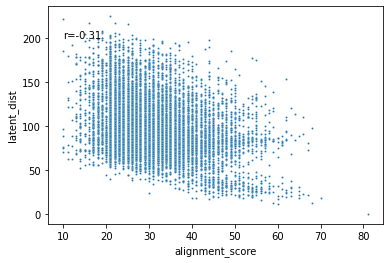

In [23]:

n = 10000
df_out = pd.DataFrame(columns=['seq1','seq2','alignment_score','latent_dist'])

for i in range(n):
    if i % 1000 == 0:
        print(i)
    seq1 = random.sample(seq_x, 1)[0]
    seq2 = random.sample(seq_y, 1)[0]
    #seq1
    mat2 = AAindexEncoding(seq1) # 20*20
    #matrix =mat2.reshape((800,))
    matrix3 = torch.from_numpy(mat2).float()
    # reshape the size 
    matrix3 = matrix3.view(1,1,20,20)
   
    #seq2
    mat4 = AAindexEncoding(seq2)
    #matrix = np.concatenate((mat3,mat4),axis=1).reshape((800,))
    matrix4 = torch.from_numpy(mat4).float()
    matrix4 = matrix4.view(1,1,20,20)
    
    latent1  =  model(matrix3,matrix4)[4].cpu().detach().numpy()
    latent2  =  model(matrix3,matrix4)[5].cpu().detach().numpy()
   
    
    #alignments
    alignments = pairwise2.align.localds(seq1, seq2, align_matrix, open=open_penalty, extend=gap_penalty)
    score_align = alignments[0].score
    #
    latent_dist = np.sqrt( np.sum(np.square(latent1 - latent2)) )
    df_out.loc[len(df_out)] = [seq1, seq2, score_align, latent_dist]

df_out.to_csv('/content/drive/MyDrive/DL/CNNVAE/Deepcat_data_latent_score1.csv',index=False)

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

print("start plotting")
sns.scatterplot(x='alignment_score',y='latent_dist',data=df_out,s=4)
#sns.lmplot(x='alignment_score',y='latent_dist',data=distance)
r,p =stats.pearsonr(df_out['alignment_score'], df_out['latent_dist'])
print(r)
plt.text(10, 200, 'r={:.2f}'.format(r))
plt.savefig('/content/drive/MyDrive/DL/CNNVAE/aligment_score.png')


Sequence reconstruction 

In [32]:
print('Read Seq')
seq_test = pd.read_csv('/content/drive/My Drive/DL/VAE/NormalCDR3_test.txt',delimiter='\t',header=None,names=['seq'])
seq_test['length'] = [len(seq) for seq in seq_test['seq']]
#select seqs <=20 length
seq_test = seq_test[ seq_test['length']<=20 ]
seq = list( seq_test['seq'] )


seq_x = random.sample(seq,5000)
seq_y = random.sample(seq,5000)



AA_matx= GetFeatures(seq_x)
AA_maty= GetFeatures(seq_y)


r1_transform_x=torch.from_numpy(AA_matx).float()
r1_transform_y=torch.from_numpy(AA_maty).float()



m1 =r1_transform_x.view(len(r1_transform_x),1,20,20)
m2 =r1_transform_y.view(len(r1_transform_y),1,20,20)
x_hat = model(m1,m2)[0]
y_hat = model(m1,m2)[2]
# get encoding layer? #1000, 20,20
#mat2 = model(m2)[2] 
result1= x_hat.view( 5000,20,20).cpu().detach().numpy()

result2= y_hat.view( len(y_hat),20,20 ).cpu().detach().numpy()



def Reverse(dict, data):
    re=np.zeros(20)
        
    for i in range(len(data)):
        if np.sum(data)==0:
            re[i]=0
        else: 
            a_min = dict.min(axis=0)[i]
            b_max = dict.max(axis=0)[i]
            re[i]= data[i]*(b_max-a_min)+(a_min)
    return re



def Reversematrix (dict,matrix):

    result = []
    for i in range(len(matrix)):
        result.append(Reverse(dict,matrix[i]))
    return np.array(result)
## d to array 

list_dat = list(d.values())
arr = np.array(list_dat)
ex = np.array(arr)
# reverse to original array 

seq_decode1 = []
for i in range(len(result1)):

    seq_decode1.append(Reversematrix(ex, result1[i]))
    
seq_decode2 = []
for i in range(len(result2)):

    seq_decode2.append(Reversematrix(ex, result2[i]))
    
print("reverted to original scale!")
    
print("==start reconstuction!--")
# 

   
def reconstructSequence(dict,data):
  result = []
  for i in range(len(data)):
    currentSeq= ''
    dict_index=list(dict.keys())
    if(i%1000==0):
      print(str(i/len(data)*100)+'%')
    for j in range(len(data[i])):
      row = data[i][j]
      max_value= np.max(row)
      if max_value <= 0.1:
        continue
      #calculate distance
      dist = []
      for key, value in dict.items():
        dist.append(distance.euclidean(dict[key], row))
      currentSeq += dict_index[np.argmin(dist)]
    result.append(currentSeq)
  return result  



seq_decode1= reconstructSequence(d,seq_decode1)

seq_decode2= reconstructSequence(d,seq_decode2)
print("Sequence reconstructed!")

#seq_decode2= ReconstructSeq(result2)
df = pd.DataFrame(columns=['seq_original_x','seq_original_y','seq_model_x','seq_model_y'])
df['seq_original'] = seq_x
df['seq_original_y']=seq_y

df['seq_model_x'] = seq_decode1
df['seq_model_y'] = seq_decode2

print("calculate accuracy")
print( len(df[df['seq_original_x']==df['seq_model_x']])/len(df) )
print( len(df[df['seq_original_y']==df['seq_model_y']])/len(df) )

df.to_csv('/content/drive/MyDrive/DL/CNNVAE/pairedAE_test_AA_seq1.csv',index=False)

        

Read Seq
reverted to original scale!
==start reconstuction!--
0.0%
20.0%
40.0%
60.0%
80.0%
0.0%
20.0%
40.0%
60.0%
80.0%
Sequence reconstructed!
calculate accuracy
0.0
0.3868


In [ ]:
r1_transform_x=torch.from_numpy(AA_matx).float()
r1_transform_y=torch.from_numpy(AA_maty).float()



m1 =r1_transform_x.view(len(r1_transform_x),1,20,20)
m2 =r1_transform_y.view(len(r1_transform_y),1,20,20)

In [27]:
print(m1.shape)
x_hat = model(m1,m2)[0]


torch.Size([5000, 1, 20, 20])
5000


In [28]:
print(x_hat.shape)

torch.Size([5000, 1, 20, 20])


In [31]:
result1= x_hat.view( 5000,20,20 ).cpu().detach().numpy()

In [30]:
result1.shape

(5000, 1, 20, 20)